In [2]:
import numpy as np
import cv2
from scipy import fftpack
from matplotlib import pyplot as plt

In [39]:
class Retinex:
     
    def set_param(self,img):
        r = img[...,2]
        g = img[...,1]
        b = img[...,0]
        self.param = [self.gau_process(r),self.gau_process(g),self.gau_process(b)]

    
    def gau_process(self,I):

        I_d = np.array(I).astype('float')
        I_log = np.log(I_d+1)
        f_I = fftpack.fft(I_d)
        Ir = img[...,0]
        sigma = [15,80,250]
        x,y = np.meshgrid(range((-(np.shape(Ir)[1]-1)/2),(np.shape(Ir)[1])/2),range((-(np.shape(Ir)[0]-1)/2),(np.shape(Ir)[0])/2))
        Reti = []

        for sig in sigma:
            Gauss = np.exp(-(x^2+y^2)/(2*sig^2))/sum(np.exp(-(x^2+y^2)/(2*sig^2)))
            fgauss = fftpack.fft2(Gauss,np.shape(I))
            fgauss = fftpack.fftshift(fgauss)
            R = fftpack.ifft2(fgauss*f_I)
            min1 = R.min()
            R_log = np.log(R-min1+1)
            R = I_log-R_log
            Reti.append(R)

        return Reti

    def clamp(self,R):
        low = R.min()
        high = R.max()
        return (255*(R-low)/(high-low)).astype('uint8')

    def getSSR(self,param):
        SSR = param[1]
        return self.clamp(SSR)

    def getMSR(self,param):
        MSR = 0.33*param[0]+0.34*param[1]+0.33*param[2]
        return self.clamp(MSR)

    def getMSRCR(self,param,CR_param,cur_l):
        G = CR_param[0]
        b = CR_param[1]
        alpha = CR_param[2]
        beta = CR_param[3]
        Ir_d = CR_param[4]
        Ig_d = CR_param[5]
        Ib_d = CR_param[6]
        CR = beta*(np.log(alpha*CR_param[4+cur_l]+1)-np.log(Ir_d+Ig_d+Ib_d+1))
        R_temp = 0.33*param[0]+0.34*param[1]+0.33*param[2]
        R = G*(CR*R_temp+b)
        return self.clamp(R)


    def SSR(self,img):
        ssr = img.copy()
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        for i in range(0,3):
            SSR = self.getSSR(self.param[i])
            ssr[...,i] = SSR 
        return ssr

    def MSR(self,img):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        msr = img.copy()
        for i in range(0,3):
            MSR = self.getMSR(self.param[i])
            msr[...,i] = MSR
        return msr 

    def MSRCR(self,img):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        msrcr = img.copy()
        G = 192
        b = -30
        alpha = 125
        beta = 46
        I_d = []
        for i in range(0,3):
            S = img[...,i]
            I_dt = np.array(S).astype('float')
            I_d.append(I_dt)
            
        MSRCR_param = [G,b,alpha,beta,I_d[0],I_d[1],I_d[2]]   
        
        for j in range(0,3):
            MSRCR = self.getMSRCR(self.param[j],MSRCR_param,j)
            msrcr[...,j] = MSRCR
        return msrcr

In [40]:
def night_car_seg(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    #kernel = np.array([[1,0,0],[0,1,0],[0,0,1]]).astype(np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = np.uint8(sure_bg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img2 = img.copy() 
    img2[markers == -1] = [255,0,0]
    pxls = zip(np.where(markers!=1))
    img3 = np.zeros_like(img)
    img3 = img3+255
    img3[pxls] = img[pxls]
    return pxls,img3


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


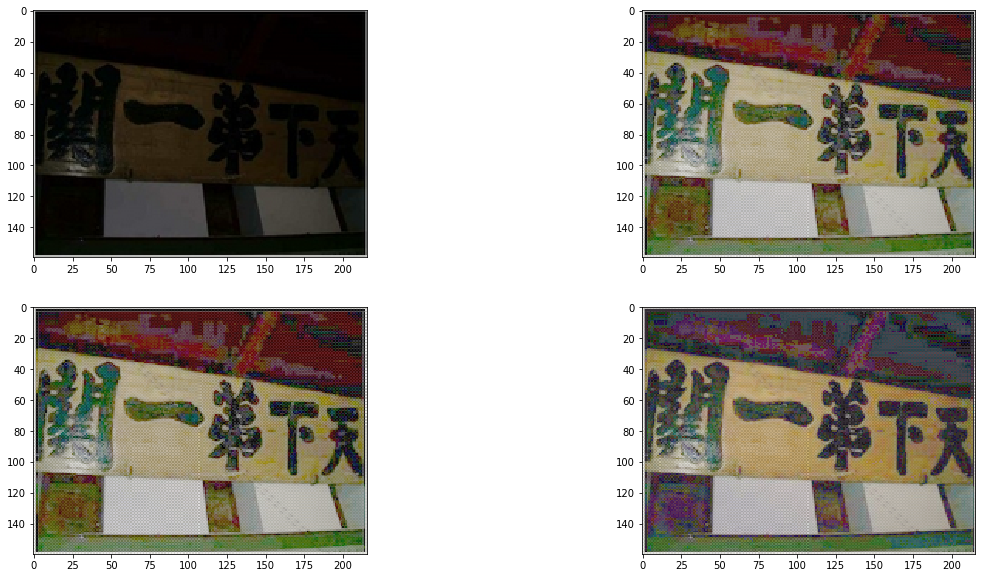

In [41]:
#img_pwd = './img/falsePos/redlight1.jpg'
img_pwd = 'test2.png'
img = cv2.imread(img_pwd)
#pxls,img3 = night_car_seg(im)

#img = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)


retinex = Retinex()
retinex.set_param(img)
ssr = retinex.SSR(img)
msr = retinex.MSR(img)
msrcr = retinex.MSRCR(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(img)
plt.subplot(222),plt.imshow(msr)
plt.subplot(223),plt.imshow(ssr)
plt.subplot(224),plt.imshow(msrcr)
plt.show()

In [27]:
def gau_process(I):

    I_d = np.array(I).astype('float')
    I_log = np.log(I_d+1)
    f_I = fftpack.fft(I_d)

    sigma = [15,80,250]
    x,y = np.meshgrid(range((-(np.shape(Ir)[1]-1)/2),(np.shape(Ir)[1])/2),range((-(np.shape(Ir)[0]-1)/2),(np.shape(Ir)[0])/2))
    Reti = []

    for sig in sigma:
        Gauss = np.exp(-(x^2+y^2)/(2*sig^2))/sum(np.exp(-(x^2+y^2)/(2*sig^2)))
        fgauss = fftpack.fft2(Gauss,np.shape(I))
        fgauss = fftpack.fftshift(fgauss)
        R = fftpack.ifft2(fgauss*f_I)
        min1 = R.min()
        R_log = np.log(R-min1+1)
        R = I_log-R_log
        Reti.append(R)

    return Reti

def clamp(R):
    low = R.min()
    high = R.max()
    return (255*(R-low)/(high-low)).astype('uint8')

def getSSR(param):
    SSR = param[1]
    return clamp(SSR)

def getMSR(param):
    MSR = 0.33*param[0]+0.34*param[1]+0.33*param[2]
    return clamp(MSR)

def getMSRCR(param,CR_param):
    G = CR_param[0]
    b = CR_param[1]
    alpha = CR_param[2]
    beta = CR_param[3]
    Ir_d = CR_param[4]
    Ig_d = CR_param[5]
    Ig_d = CR_param[6]
    CRr = beta*(np.log(alpha*Ir_d+1)-np.log(Ir_d+Ig_d+Ib_d+1))
    R_temp = 0.33*param[0]+0.34*param[1]+0.33*param[2]
    R = G*(CRr*R_temp+b)
    return clamp(R)

In [28]:
img = cv2.imread('test2.png')



#setting parameter
Ib = img[...,0]
Ig = img[...,1]
Ir = img[...,2]
G = 192
b = -30
alpha = 125
beta = 46

Ib_d = np.array(Ib).astype('float')
Ir_d = np.array(Ir).astype('float')
Ig_d = np.array(Ig).astype('float')



#manipulate RGB

red_param = gau_process(Ir)
green_param = gau_process(Ig)
blue_param = gau_process(Ib)


#SSR:

SSR_r = getSSR(red_param)
SSR_g = getSSR(green_param)
SSR_b = getSSR(blue_param)

#MSR:

MSR_r = getMSR(red_param)
MSR_g = getMSR(green_param)
MSR_b = getMSR(blue_param)


#MSRCR

MSRCR_param = [G,b,alpha,beta,Ir_d,Ig_d,Ib_d]

MSRCR_r = getMSRCR(red_param,MSRCR_param)
MSRCR_g = getMSRCR(green_param,MSRCR_param)
MSRCR_b = getMSRCR(blue_param,MSRCR_param)





/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


In [29]:

ssr = img.copy()
ssr[:,:,0] = SSR_r
ssr[:,:,1] = SSR_g
ssr[:,:,2] = SSR_b

msr = img.copy()
msr[...,0] = MSR_r
msr[...,1] = MSR_g
msr[...,2] = MSR_b

msrcr = img.copy()
msrcr[...,0] = MSRCR_r
msrcr[...,1] = MSRCR_g
msrcr[...,2] = MSRCR_b

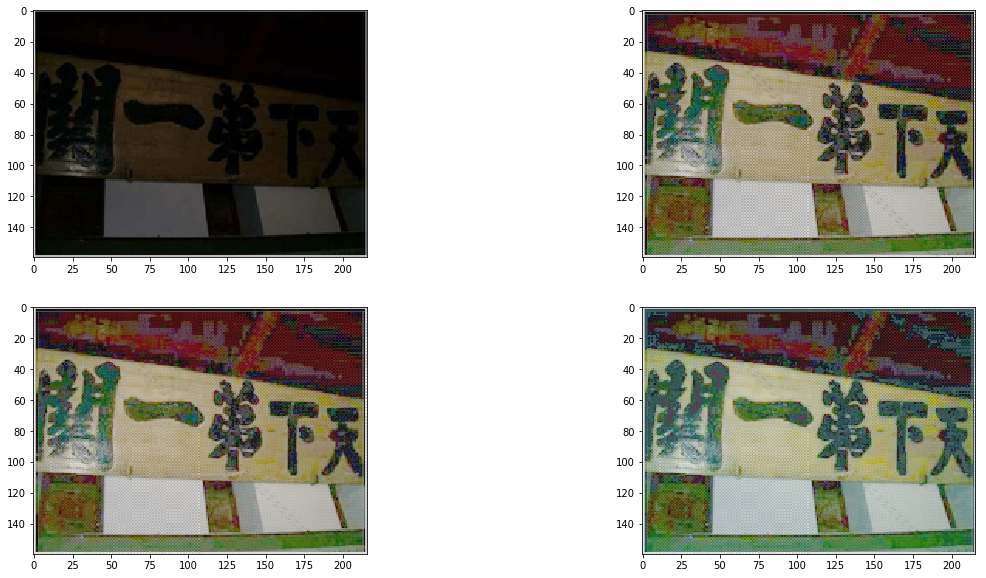

In [30]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(img)
plt.subplot(222),plt.imshow(ssr)
plt.subplot(223),plt.imshow(msr)
plt.subplot(224),plt.imshow(msrcr)
plt.show()

In [ ]:
img = cv2.imread('test2.png')

